In [318]:
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import log_loss,accuracy_score
from sklearn.datasets import make_blobs,make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.colors

#  Sample Data

In [321]:
data,labels = make_moons(n_samples=1000,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


# Color Map

In [322]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

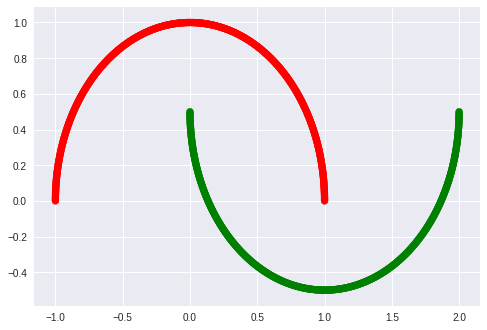

In [323]:
plt.style.use('seaborn')
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

# Train-Test-Split

In [324]:
X_train,X_val,Y_train,Y_val = train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)

(750, 2) (750,) (250, 2) (250,)


# One hot encoding of Y_train

In [325]:
enc = OneHotEncoder()
Y_train_one_hot = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
print(Y_train_one_hot.shape)

(750, 2)


/home/akansh/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [326]:
Y_train_one_hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

# Multi-Layer-Perceptron/Feed Forward Nueral Network Class
## With optimizers : Momentum , AdaGrad, RMSProp, Adam

In [327]:
class Nueral_Network:

    def __init__(self,hidden_layer=[2,2,2,2],output_layer=4,num_layers = 3,init_algo = 'random',activation='sigmoid'):
        np.random.seed(0)
        self.activation = activation
        self.params = {}
        self.leaky_slope = 0.1
        self.update_params = {}
        self.gradients = {}
        self.num_layers = num_layers
        
        if(init_algo == 'random'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.random.randn(hidden_layer[i-1],hidden_layer[i])
                self.params['B' + str(i)] = np.random.randn(1,hidden_layer[i])
        elif(init_algo == 'zero'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.zeros((hidden_layer[i-1],hidden_layer[i]))
                self.params['B' + str(i)] = np.zeros((1,hidden_layer[i]))
        elif(init_algo == 'xavier'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.random.randn(hidden_layer[i-1],hidden_layer[i])*np.sqrt(1/hidden_layer[i-1])
                self.params['B' + str(i)] = np.random.randn(1,hidden_layer[i])
        elif(init_algo == 'he'):
            for i in range(1,num_layers + 1):
                self.params['W' + str(i)] = np.random.randn(hidden_layer[i-1],hidden_layer[i])*np.sqrt(2/hidden_layer[i-1])
                self.params['B' + str(i)] = np.random.randn(1,hidden_layer[i])
        
            
        for i in range(1,num_layers+1):
            self.update_params['v_w' + str(i)] = 0
            self.update_params['v_b' + str(i)] = 0
            self.update_params['m_w' + str(i)] = 0
            self.update_params['m_b' + str(i)] = 0
            
    
    def forward_activation(self,X):
        
        if(self.activation == 'sigmoid'):
            return(1.0/(1.0 + np.exp(-X)))
        elif(self.activation == 'tanh'):
            return(np.tanh(X))
        elif(self.activation == 'relu'):
            return(np.maximum(0,X))
        elif(self.activation == 'leaky relu'):
            return(np.maximum(self.leaky_slope * X,X))
    
    def grad_activation(self,X):
        if(self.activation == 'sigmoid'):
            return(X * (1-X))
        elif(self.activation == 'tanh'):
            return(1-np.square(X))
        elif(self.activation == 'relu'):
            return(1.0 * (X>0))

        elif(self.activation == 'leaky relu'):
            d = np.zeros_like(X)
            d[X<=0] = self.leaky_slope
            d[X>0] = 1.0
            return d
            
    
    def softmax(self,X):
        exps = np.exp(X) # (N,2)
        sums_exp = np.sum(exps,axis=1).reshape(-1,1) #(N,1)
        return(exps/sums_exp) #(N,2) / (N,1) --> (N,2)
        
    
    def forward_pass(self,X):
        
        # Layer 1(Hidden)
        self.params['A1'] = np.matmul(X,self.params['W1']) + self.params['B1'] #(N,2) * (2,4)-->(N,4) + (N,4)
        self.params['H1'] = self.forward_activation(self.params['A1']) # (N,4)
        
        #Layer 2(Hidden)
        self.params['A2'] = np.matmul(self.params['H1'],self.params['W2']) + self.params['B2'] #(N,4) * (4,3)-->(N,3)
        self.params['H2'] = self.forward_activation(self.params['A2']) #(N,3)
        
        #Layer 3(Output)
        self.params['A3'] = np.matmul(self.params['H2'],self.params['W3']) + self.params['B3'] #(N,3) * (3,2)-->(N,2)
        self.params['H3'] = self.softmax(self.params['A3']) #(N,2)
        
        return(self.params['H3']) #(N,2)
    
    def grad(self,X,Y):
        
        self.forward_pass(X)
        
        #Layer 3
        self.gradients['dA3'] = self.params['H3'] - Y #(N,2) - (N,2) -->(N,2)
        self.gradients['dW3'] = np.matmul(self.params['H2'].T,self.gradients['dA3']) # (3,N) * (N,2) -->(3,2)
        self.gradients['dB3'] = np.sum(self.gradients['dA3'],axis=0).reshape(1,-1) 
        
        #Layer 2 
        self.gradients['dH2'] = np.matmul(self.gradients['dA3'],self.params['W3'].T) #(N,2) * (2,3) -- >(N,3)
        self.gradients['dA2'] = np.multiply(self.gradients['dH2'],self.grad_activation(self.params['H2'])) #(N,3) * (N,3)-->(N,3)
        self.gradients['dW2'] = np.matmul(self.params['H1'].T,self.gradients['dA2']) #(4,N) * (N,3)   --> (4,3)
        self.gradients['dB2'] = np.sum(self.gradients['dA2'],axis=0).reshape(1,-1)
        
        #Layer 1
        self.gradients['dH1'] = np.matmul(self.gradients['dA2'],self.params['W2'].T) #(N,3) * (3,4) -->(N,4)
        self.gradients['dA1'] = np.multiply(self.gradients['dH1'],self.grad_activation(self.params['H1'])) #(N,4) * (N,4)
        self.gradients['dW1'] = np.matmul(X.T,self.gradients['dA1']) #(2,N) * (N,4) -->(2,4)
        self.gradients['dB1'] = np.sum(self.gradients['dA1'],axis=0).reshape(1,-1)
        
    def fit(self,X,Y,epochs=1,eta=1,display_loss = False,algo='GD',gamma=0.8,eps = 1e-8,beta = 0.8,beta1=0.8,beta2=0.8):
        
        if(display_loss):
            loss = {}
        
        for epoch in tqdm_notebook(range(epochs),unit="epoch",total=epochs):
            
            if(algo == 'GD'):
            
                self.grad(X,Y)

                m = X.shape[0]
                
                self.params['W1'] -= eta * (self.gradients['dW1']/m)
                self.params['W2'] -= eta * (self.gradients['dW2']/m)
                self.params['W3'] -= eta * (self.gradients['dW3']/m)
                self.params['B1'] -= eta * (self.gradients['dB1']/m)
                self.params['B2'] -= eta * (self.gradients['dB2']/m)
                self.params['B3'] -= eta * (self.gradients['dB3']/m)

                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
            
            elif(algo == 'Momentum'):
                self.grad(X,Y)
                m = X.shape[0]
                
                for i in range(1,self.num_layers+1):
                
                    self.update_params['v_w' + str(i)] = gamma*self.update_params['v_w' + str(i)] + eta * (self.gradients['dW' + str(i)])/m
                    self.update_params['v_b' + str(i)] = gamma*self.update_params['v_b' + str(i)] + eta * (self.gradients['dB' + str(i)])/m
                    self.params['W' + str(i)] -= self.update_params['v_w' + str(i)]
                    self.params['B' + str(i)] -= self.update_params['v_b' + str(i)]
                
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
            
            elif(algo == 'AdaGrad'):
                self.grad(X,Y)
                m = X.shape[0]
                
                for i in range(1,self.num_layers+1):
                    
                    self.update_params['v_w' + str(i)] = self.update_params['v_w' + str(i)] + ((self.gradients['dW' + str(i)]/m) ** 2)
                    self.update_params['v_b' + str(i)] = self.update_params['v_b' + str(i)] + ((self.gradients['dB' + str(i)]/m) ** 2)
                    self.params['W' + str(i)] -= (eta/np.sqrt(self.update_params['v_w' + str(i)]+eps)) * self.gradients['dW' + str(i)]/m
                    self.params['B' + str(i)] -= (eta/np.sqrt(self.update_params['v_b' + str(i)]+eps)) * self.gradients['dB' + str(i)]/m
                
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
            
            elif(algo == 'RMSProp'):
                self.grad(X,Y)
                m = X.shape[0]
                
                for i in range(1,self.num_layers+1):
                    
                    self.update_params['v_w' + str(i)] = beta*self.update_params['v_w' + str(i)] + (1-beta)*((self.gradients['dW' + str(i)]/m) ** 2)
                    self.update_params['v_b' + str(i)] = beta*self.update_params['v_b' + str(i)] + (1-beta)*((self.gradients['dB' + str(i)]/m) ** 2)
                    self.params['W' + str(i)] -= (eta/np.sqrt(self.update_params['v_w' + str(i)]+eps)) * self.gradients['dW' + str(i)]/m
                    self.params['B' + str(i)] -= (eta/np.sqrt(self.update_params['v_b' + str(i)]+eps)) * self.gradients['dB' + str(i)]/m
                    
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
            
            elif(algo == 'Adam'):
                self.grad(X,Y)
                m = X.shape[0]
                num_updates = 0
                for i in range(1,self.num_layers+1):
                    num_updates+=1

                    self.update_params['m_w' + str(i)] = beta1*self.update_params['m_w' + str(i)] + ((1-beta1) * self.gradients['dW' + str(i)]/m) 
                    self.update_params['m_b' + str(i)] = beta1*self.update_params['m_b' + str(i)] + ((1-beta1) * self.gradients['dB' + str(i)]/m) 
                    self.update_params['v_w' + str(i)] = beta2*self.update_params['v_w' + str(i)] + ((1-beta2) * ((self.gradients['dW' + str(i)]/m)**2))
                    self.update_params['v_b' + str(i)] = beta2*self.update_params['v_b' + str(i)] + ((1-beta2) * ((self.gradients['dB' + str(i)]/m)**2))
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))

                    self.params['W' + str(i)] -= (eta/np.sqrt(v_w_hat + eps))* m_w_hat
                    self.params['B' + str(i)] -= (eta/np.sqrt(v_b_hat + eps))* m_b_hat
                
                Y_pred = self.predict(X)
                loss[epoch] = log_loss(np.argmax(Y,axis=1),Y_pred)
                    
                

        if(display_loss):
            plt.plot(list(loss.values()),'-o',markersize=5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    
    def predict(self,X):
        Y_pred = []
        return(np.asarray(self.forward_pass(X))) #(N,2)
        
        
                            
        
        
    

# Model Running

In [353]:
mlp = Nueral_Network(init_algo='xavier',activation='leaky relu')

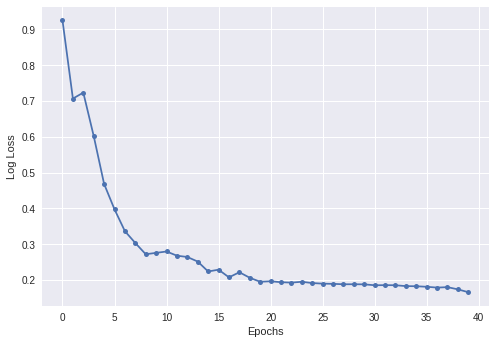

CPU times: user 300 ms, sys: 19.6 ms, total: 320 ms
Wall time: 314 ms


In [354]:
%%time 
mlp.fit(X_train,Y_train_one_hot,display_loss=True,epochs=40,eta=0.25,beta=0.8,algo='Adam')

In [355]:
Y_pred = mlp.predict(X_train)
Y_pred_bin = np.argmax(Y_pred,axis=1)
Y_pred_bin.shape


(750,)

# Training Accuracy

In [356]:
accuracy_train = accuracy_score(Y_train.reshape(-1,1),Y_pred_bin)
print(f'The training accuracy obtained is:{accuracy_train*100}')

The training accuracy obtained is:93.33333333333333


In [339]:
Y_pred = mlp.predict(X_val)
Y_pred_bin_test = np.argmax(Y_pred,axis=1)

print(Y_pred_bin_test.shape)

(250,)


# Testing Accuracy

In [340]:
accuracy_test = accuracy_score(Y_val.reshape(-1,1),Y_pred_bin_test)
print(f'The validation accuracy obtained is:{accuracy_test*100}')

The validation accuracy obtained is:91.60000000000001


# Compared optimizers for good intuition about these.
### Not reproducable as they were done at time when random_state was not mentioned in train_test_split

In [401]:
print("GD ,epochs=100,eta=0.5,ACCURACY:",69)
print("Momentum ,epochs=100,eta=0.5,gamma=0.8,time:340ms,ACCURACY:",89)
print("AdaGrad ,epochs=100,eta=0.5,eps=1e-8,time:353ms,ACCURACY:",91.066)
print("RMSProp ,epochs=100,eta=0.5,eps=1e-8,time:346ms,ACCURACY:",89.866)
print("Adam ,epochs=100,eta=0.5,eps=1e-8,time:346ms,ACCURACY:",91.60)

GD ,epochs=100,eta=0.5,ACCURACY: 69
Momentum ,epochs=100,eta=0.5,gamma=0.8,time:340ms,ACCURACY: 89
AdaGrad ,epochs=100,eta=0.5,eps=1e-8,time:353ms,ACCURACY: 91.066
RMSProp ,epochs=100,eta=0.5,eps=1e-8,time:346ms,ACCURACY: 89.866
Adam ,epochs=100,eta=0.5,eps=1e-8,time:346ms,ACCURACY: 91.6


In [402]:
print("GD ,epochs=1000,eta=0.15,time:1.53 s,ACCURACY:",92.8)
print("Momentum ,epochs=1000,eta=0.15,gamma=0.8,time:1.43s,ACCURACY:",92.93)
print("AdaGrad ,epochs=1000,eta=0.15,eps=1e-8,time:353ms,ACCURACY:",93.2)
print("RMSProp ,epochs=1000,eta=0.15,eps=1e-8,time:1.52s,ACCURACY:",92.6)
print("Adam ,epochs=1000,eta=0.15,eps=1e-8,time:1.75s,ACCURACY:",94.3)

GD ,epochs=1000,eta=0.15,time:1.53 s,ACCURACY: 92.8
Momentum ,epochs=1000,eta=0.15,gamma=0.8,time:1.43s,ACCURACY: 92.93
AdaGrad ,epochs=1000,eta=0.15,eps=1e-8,time:353ms,ACCURACY: 93.2
RMSProp ,epochs=1000,eta=0.15,eps=1e-8,time:1.52s,ACCURACY: 92.6
Adam ,epochs=1000,eta=0.15,eps=1e-8,time:1.75s,ACCURACY: 94.3
